# Und das Wort ist Fleisch geworden
* https://textmining.wp.hs-hannover.de/Preprocessing.html
* Tagset: https://homepage.ruhr-uni-bochum.de/stephen.berman/Korpuslinguistik/Tagsets-STTS.html

In [1]:
import pandas as pd
import nltk
import json
from pathlib import Path
from HanTa import HanoverTagger as ht
import glob
import math
import pickle

# Do once
#nltk.download('punkt')

In [2]:
csv_path = Path('../export/csv_for_infographics')

## Lemmatize / Tag and store as CSV (only once, then goto: next chapter)
Store lemmatized and tagged data as json because of performance issues. Loading a csv with (many!) dicts is very slow and like flying from BER...  
Split it up to store it on github (max filesize = 100mb)

In [3]:
tagger = ht.HanoverTagger('morphmodel_ger.pgz')

In [4]:
df_votum_raw = pd.concat([
    pd.read_csv(Path('../export/votum/votum_0.csv')),
    pd.read_csv(Path('../export/votum/votum_1.csv'))
])

# Remove empty texts
df_votum_raw = df_votum_raw[df_votum_raw.text.notna()]

In [5]:
# Start tagging
records = []
for i, row in df_votum_raw.iterrows():
    lemm = nltk.tokenize.word_tokenize(row['text'], language='german')

    records.append({
        'sitzung_date': row['sitzung_date'],
        'dokument_titel': row['dokument_titel'],
        'name': row['name'],
        'vorname': row['vorname'],
        'partei': row['partei'],
        'jahrgang': row['jahrgang'],
        'geschlecht': row['geschlecht'],
        'funktion': row['funktion'],
        'ismember': row['ismember'],
        'tags': tagger.tag_sent(lemm, taglevel=1),
    })

In [6]:
# Split
chunks = 7
bucketsize = math.ceil(len(records) / chunks)
for i in range(0, chunks):
    subrecords = []
    for j in range(bucketsize * i, bucketsize * ( i + 1 )):
        if j < len(records):
            subrecords.append(records[j])

    # Store
    with open(Path('../export/tags/tag_%s.json' % i), 'w', encoding='utf-8') as f:
        f.write(json.dumps(subrecords, ensure_ascii=False))

print("finito")

finito


## Load stemmatized Data

In [9]:
records = []
for f in glob.glob(str(Path('../export/tags/*.json'))):
    records = records + json.load(open(f, 'r', encoding='utf-8'))

print(len(records))

80292


In [10]:
# Members only, no Presidents
r_members = list(filter(lambda x: x['ismember'] == True, records))
r_members = list(filter(lambda x: x['funktion'] not in ['Präsidium', '2. Vizepräsidium', '1. Vizepräsidium'], r_members))
print(len(r_members))

59496


## Analyse who said what

### Export Nouns for each gender (already done)
!! Takes ages. Skip this and load files from disk

In [11]:
# Select only Nouns
list_m = []
list_w = []
for r in r_members:
    tags = [lemma for (word,lemma,pos) in r['tags'] if pos == "NN" or pos == "NE"]
    if r['geschlecht'] == 'm': list_m = list_m + tags
    elif r['geschlecht'] == 'w': list_w = list_w + tags

# Store files
with open(Path('../export/nouns/nouns_m.txt'), 'wb') as f:
    pickle.dump(list_m, f)

with open(Path('../export/nouns/nouns_w.txt'), 'wb') as f:
    pickle.dump(list_w, f)

### Load Noun files from Disk

In [12]:
with open(Path('../export/nouns/nouns_m.txt'), 'rb') as fp:
    list_m = pickle.load(fp)

with open(Path('../export/nouns/nouns_w.txt'), 'rb') as fp:
    list_w = pickle.load(fp)

### Top m/w topics and how the differ to the other sex

In [13]:
def get_freqdist_df(l):
    fdist = nltk.FreqDist(l)
    fdist = fdist.most_common(100)
    df_dist = pd.DataFrame(fdist, columns=['w', 'count'])
    df_dist.reset_index(drop=False, inplace=True)
    return df_dist

df_m = get_freqdist_df(list_m)
df_m['geschlecht'] = 'm'

df_w = get_freqdist_df(list_w)
df_w['geschlecht'] = 'w'

df_concat = pd.concat([df_w, df_m])

# Rename w, ambiguouse
df_concat.rename(columns={'w': 'noun'}, inplace=True)

In [14]:
df_pivot = pd.pivot_table(df_concat, index='noun', columns='geschlecht', values='count')

# Indexieren (max = 100)
df_pivot['m_index'] = round(100 / df_pivot['m'].max() * df_pivot['m'], 1)
df_pivot['w_index'] = round(100 / df_pivot['w'].max() * df_pivot['w'], 1)
df_pivot['diff'] = (df_pivot['m_index'] - df_pivot['w_index'])
df_pivot['diffabs'] = abs(df_pivot['m_index'] - df_pivot['w_index'])

df_pivot.sort_values('w', ascending=False).head(20)

geschlecht,m,w,m_index,w_index,diff,diffabs
noun,,,,,,
Kanton,41604.0,17663.0,100.0,100.0,0.0,0.0
Jahr,31047.0,12839.0,74.6,72.7,1.9,1.9
Zürich,30067.0,12479.0,72.3,70.7,1.6,1.6
Postulat,17620.0,7930.0,42.4,44.9,-2.5,2.5
Gemeinde,17434.0,7866.0,41.9,44.5,-2.6,2.6
Franken,17585.0,6539.0,42.3,37.0,5.3,5.3
Antrag,15646.0,6045.0,37.6,34.2,3.4,3.4
Kind,5333.0,5695.0,12.8,32.2,-19.4,19.4
Prozent,12915.0,5411.0,31.0,30.6,0.4,0.4


<AxesSubplot:title={'center':'Nomen mit grösstem Geschlechterunterschied'}, ylabel='noun'>

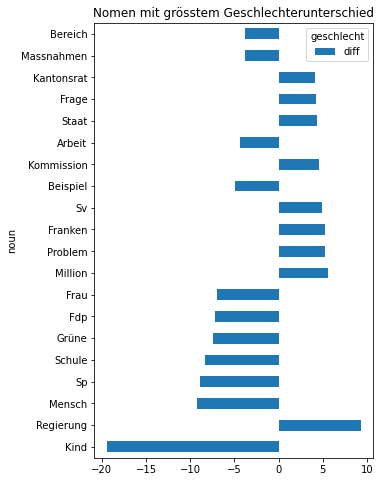

In [15]:
# Show topic with max difference
df_diff = df_pivot.sort_values('diffabs', ascending=False).head(20)
df_diff.to_csv(csv_path / 'nouns_spokben_differ_most_between_gender.csv')
df_diff[['diff']].plot.barh(figsize=(5, 8), title='Nomen mit grösstem Geschlechterunterschied')

In [16]:
df_diff

geschlecht,m,w,m_index,w_index,diff,diffabs
noun,,,,,,
Kind,5333.0,5695.0,12.8,32.2,-19.4,19.4
Regierung,13654.0,4151.0,32.8,23.5,9.3,9.3
Mensch,4580.0,3570.0,11.0,20.2,-9.2,9.2
Sp,4543.0,3505.0,10.9,19.8,-8.9,8.9
Schule,3734.0,3060.0,9.0,17.3,-8.3,8.3
Grüne,4221.0,3098.0,10.1,17.5,-7.4,7.4
Fdp,6663.0,4100.0,16.0,23.2,-7.2,7.2
Frau,3474.0,2722.0,8.4,15.4,-7.0,7.0
Million,13785.0,4863.0,33.1,27.5,5.6,5.6


[csv Daten Nomen mit grössten relativem Unterschied herunterladen](../export/csv_for_infographics/nouns_spoken_differ_most_between_gender.csv)

### Find topic that differ most (in this case: Remove duplicate topics, see, whats remains)

In [17]:
# Remove duplicates
df_concat = df_concat.drop_duplicates(subset=['noun'], keep = False)

In [18]:
list(df_concat[df_concat.geschlecht == 'w']['noun'])

['Familie',
 'Jugendliche',
 'Angebot',
 'Eltern',
 'Umsetzung',
 'Universität',
 'Schüler',
 'Bildung',
 'Grundlage',
 'Folge',
 'Personal']

In [19]:
list(df_concat[df_concat.geschlecht == 'm']['noun'])

['Herr',
 'Sache',
 'Wort',
 'Vorstoss',
 'Regierungsrat',
 'Parlament',
 'Winterthur',
 'Schluß',
 'Geschäft',
 'Politik',
 'Flughafen']